# Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
import lightgbm as lgb
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/train_data_processed.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_data_processed.csv')

In [4]:
X = train_df.drop('isFraud', axis=1)
y = train_df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train simple base model

In [5]:
clf = lgb.LGBMClassifier(random_state=50)
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.982136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17068
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317078
[LightGBM] [Info] Start training from score -3.317078


LGBMClassifier(random_state=50)

## Results analysis

In [6]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.9786
Validation accuracy: 0.9774


In [7]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9790    0.9980    0.9884    170963
           1     0.8814    0.4089    0.5587      6199

    accuracy                         0.9774    177162
   macro avg     0.9302    0.7035    0.7735    177162
weighted avg     0.9756    0.9774    0.9734    177162



Validation AUC: 0.9259


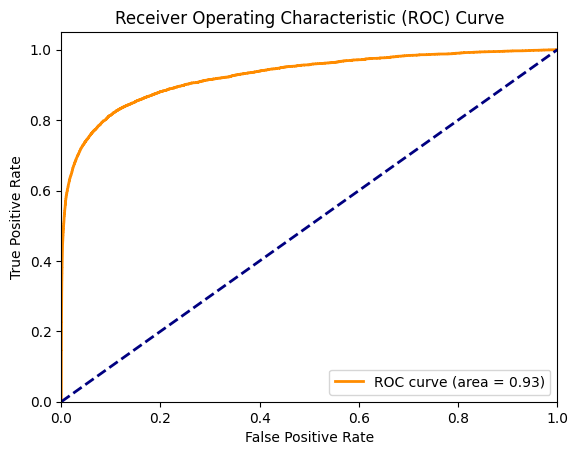

In [8]:
val_proba = clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Most important features

Top 25 Feature ranking:

1. card1 (182)
2. LogTransactionAmt (164)
3. card2 (153)
4. addr1 (122)
5. C13 (118)
6. D1 (102)
7. P_emaildomain_freq (84)
8. D15 (74)
9. C1 (69)
10. D4 (69)
11. C2 (65)
12. card5 (64)
13. C14 (63)
14. C11 (58)
15. C6 (57)
16. card3 (54)
17. D10 (49)
18. C9 (43)
19. Transaction_hour (42)
20. card6_debit (39)
21. V87 (32)
22. C12 (31)
23. V310 (30)
24. V53 (28)
25. ProductCD_R (27)



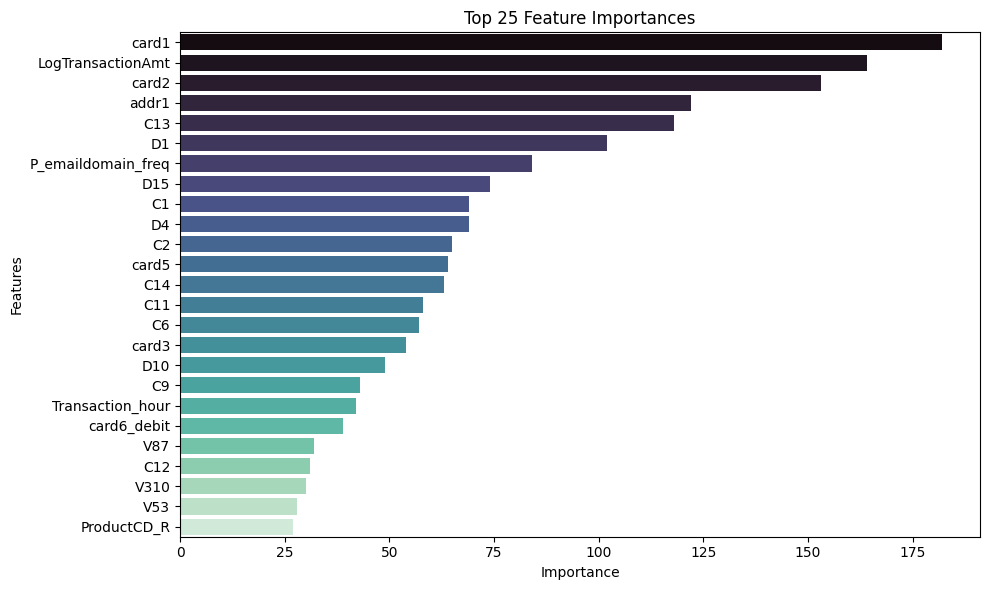

In [9]:
importances = clf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
n_features = 25

indices = np.argsort(importances)[::-1][:n_features]

print(f"Top {n_features} Feature ranking:\n")
for i in range(len(indices)):
    print(f"{i + 1}. {feature_names[indices[i]]} ({importances[indices[i]]})")
print('')

top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette="mako", legend=False, hue=top_features)
plt.title(f"Top {n_features} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

We will take the most important features in order to reduce the model complexity without affecting much its performance

In [10]:
X_important_train = X_train[top_features]
X_important_val = X_val[top_features]

In [11]:
clf = lgb.LGBMClassifier(random_state=50)
clf.fit(X_important_train, y_train)

[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317078
[LightGBM] [Info] Start training from score -3.317078


LGBMClassifier(random_state=50)

In [12]:
y_pred_train = clf.predict(X_important_train)
y_pred_val = clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.9776
Validation accuracy: 0.977


In [13]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9786    0.9980    0.9882    170963
           1     0.8791    0.3975    0.5474      6199

    accuracy                         0.9770    177162
   macro avg     0.9288    0.6978    0.7678    177162
weighted avg     0.9751    0.9770    0.9728    177162



Validation AUC: 0.92


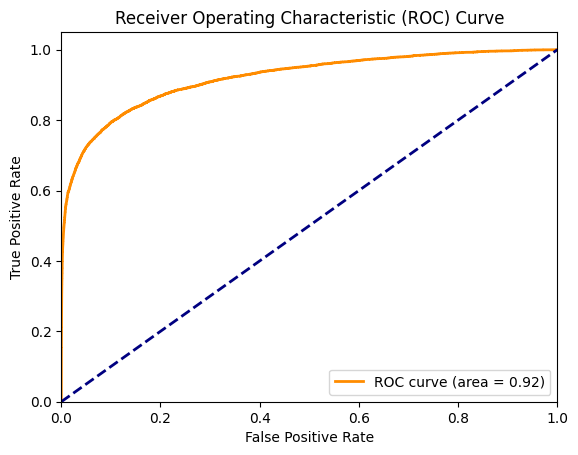

In [14]:
val_proba = clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Since the performance does not decrease significantly, we can use the top 25 features to train a simpler model

# Hyperparameter tuning

The following code optimizes hyperparameters for a LightGBM classifier using RandomizedSearchCV. A LightGBM classifier is initialized with a fixed random state to ensure reproducibility. RandomizedSearchCV is then used to perform a randomized search over a set of hyperparameters, evaluating 25 different combinations using 3-fold cross-validation. Finally, the best hyperparameters and the corresponding F1 score are printed, offering insight into the optimal configuration for the LightGBM model based on the specified parameter grid.

In [15]:
clf = lgb.LGBMClassifier(random_state=50)

param_grid = {
    'num_leaves': np.arange(20, 91, step=10),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': np.arange(7, 19, step=3),
    'min_data_in_leaf': np.arange(20, 101, step=20),
    'feature_fraction': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=25, cv=3, scoring='roc_auc', verbose=3, random_state=50, n_jobs=-1)

random_search.fit(X_important_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best Recall score: ", random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 25
[LightGBM] [Info] [bi

In [16]:
best_params = random_search.best_params_

best_clf = lgb.LGBMClassifier(**best_params, random_state=50)
best_clf.fit(X_important_train, y_train)

scores = cross_val_score(best_clf, X_important_val, y_val, cv=5, scoring='roc_auc')
print("Roc AUC scores from cross-validation: ", scores)
print("Mean Roc AUC score: ", scores.mean())

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317078
[L

In [17]:
y_pred_train = best_clf.predict(X_important_train)
y_pred_val = best_clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Train accuracy: 0.9812
Validation accuracy: 0.9792


In [18]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9807    0.9981    0.9893    170963
           1     0.8956    0.4581    0.6062      6199

    accuracy                         0.9792    177162
   macro avg     0.9382    0.7281    0.7977    177162
weighted avg     0.9777    0.9792    0.9759    177162



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Validation AUC: 0.9409


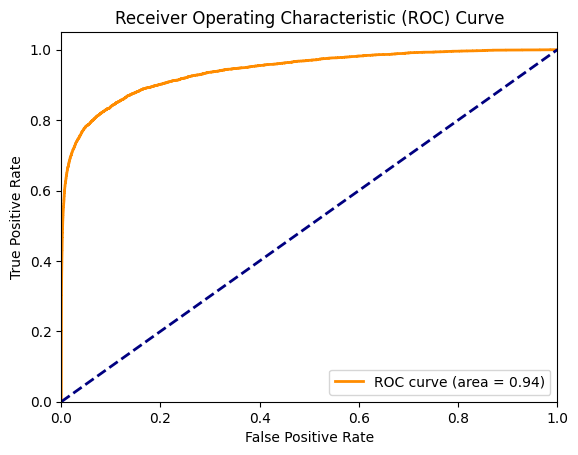

In [19]:
val_proba = best_clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The ROC curve is well above the diagonal baseline, indicating the model’s high effectiveness in distinguishing between fraudulent and non-fraudulent transactions. This high AUC value signifies that the model has a strong true positive rate while maintaining a low false positive rate.

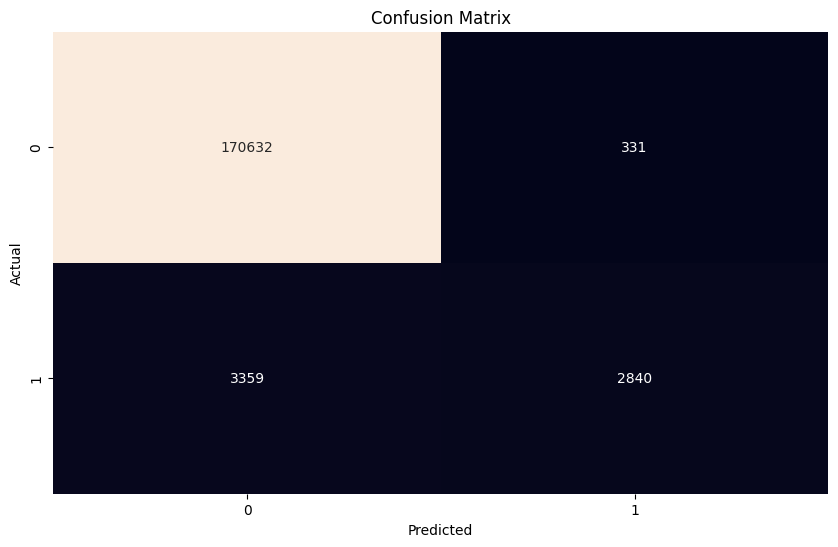

In [20]:
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model demonstrates a strong ability to correctly identify non-fraudulent transactions and maintain a high precision. However, the recall is relatively low, indicating that the model still misses a significant number of fraudulent transactions.

In [21]:
X_test = test_df[top_features + ['TransactionID']]

In [22]:
start_time = time.time()
test_predictions = best_clf.predict(X_test.drop(columns=['TransactionID']))
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Inference time: 5.726014 seconds


In [25]:
model_filename = 'lightgbm_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_clf, f)

model_size = os.path.getsize(model_filename) / 1024 / 1024
print(f"Model size: {model_size:.2f} MB")

Model size: 0.82 MB


In [26]:
test_predictions = best_clf.predict_proba(X_test.drop(columns=['TransactionID']))[:, 1]

submission = pd.DataFrame({
    'TransactionID': X_test['TransactionID'],
    'isFraud': test_predictions
})

submission.to_csv('submission_lightgbm.csv', index=False)

print("Submission file created successfully!")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Submission file created successfully!
